In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import datetime
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller, acf, pacf

%matplotlib inline

DATE
2017-05-01    6.8843
2017-06-01    6.8066
2017-07-01    6.7694
2017-08-01    6.6670
2017-09-01    6.5144
Name: EXCHUS, dtype: float64


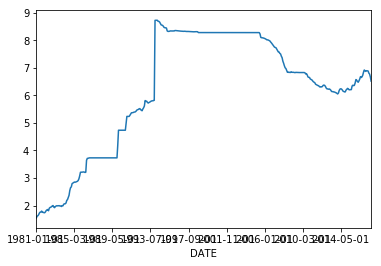

In [2]:
# Read in the data
series = pd.read_csv('EXCHUS.csv', header=0, index_col=0, squeeze=True)
#series.loc[series == '.'] = '0.1'
series= pd.to_numeric(series)
print (series.tail())
series.plot()

# Use Augmented Dickey Fuller test to see if the time series has a trend. 

If p-value > 0.05, then accept null hypothesis that the time series is not stationary

If p-value < 0.05, then reject null hypothesis, and the time series is stationary

p-value is 0.00547


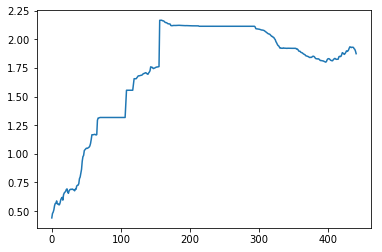

In [16]:
#try to remove variance using log transform
X = series.values
X = np.log(X)
result = adfuller(X)
print ('p-value is %.5f' % result[1]) #p-value
plt.plot(X)

#try power transform...

# Differencing:

Differencing is a method to remove the time dependence, which includes trends and seasonality.

p-value is 0.00000


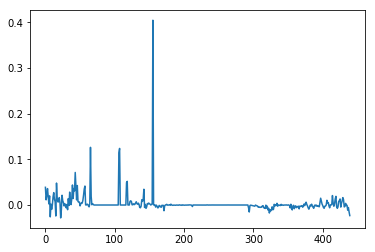

In [4]:
#manually differencing
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff = difference(X, 1)
plt.plot(diff)

"""
#using pandas function
diff = series.diff() #shift
diff.plot()
"""

result = adfuller(diff)
print ('p-value is %.5f' % result[1]) #p-value

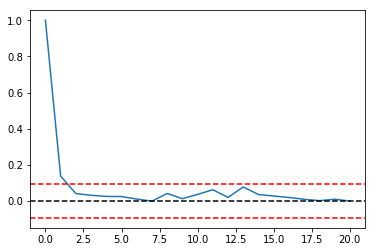

In [13]:
#plot ACF for diff

diff_acf = acf(diff, nlags=20)
plt.plot(diff_acf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--', color = 'red')

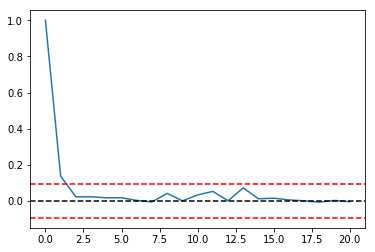

In [12]:
#plot PACF for diff

diff_pacf = pacf(diff, nlags=20)
plt.plot(diff_pacf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--', color = 'red')

# ARIMA model

AR: Autoregression. Uses the dependent relationship between an observation and some number of lagged observations

I: Integrated. The use of differencing of raw observations to make the time series stationary

MA: Moving Average. Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

ARIMA(p,d,q):

p: number of lag observations included in the AR model -> lag order

d: number of times the raw observations are differenced -> degree of differencing

q: size of moving average window -> order of moving average

Data need to be stationary inorder to use the linear regression model

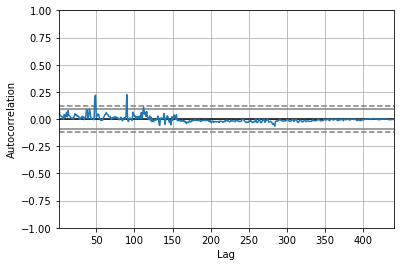

In [7]:
autocorrelation_plot(diff)

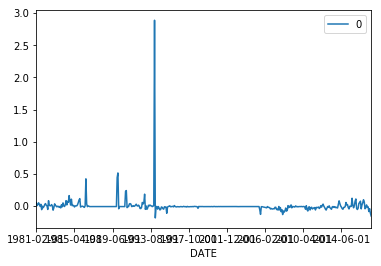

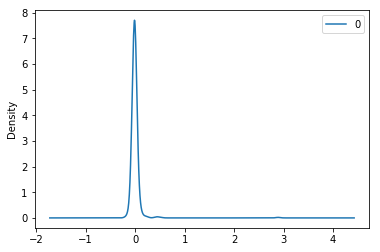

In [17]:
model = ARIMA(series, order=(1, 1, 0))
model_fit = model.fit(disp=0)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [35]:
#log transform the data
X = np.log(series.values)


size = int(len(X)*0.8)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%.3f, expected=%.3f' % (yhat, obs))

predicted=1.924, expected=1.921
predicted=1.925, expected=1.920
predicted=1.923, expected=1.913
predicted=1.916, expected=1.915
predicted=1.919, expected=1.908
predicted=1.911, expected=1.897
predicted=1.899, expected=1.895
predicted=1.898, expected=1.895
predicted=1.898, expected=1.887
predicted=1.889, expected=1.883
predicted=1.886, expected=1.882
predicted=1.885, expected=1.876
predicted=1.878, expected=1.871
predicted=1.874, expected=1.868
predicted=1.871, expected=1.865
predicted=1.868, expected=1.857
predicted=1.859, expected=1.854
predicted=1.857, expected=1.852
predicted=1.854, expected=1.849
predicted=1.852, expected=1.848
predicted=1.851, expected=1.843
predicted=1.846, expected=1.841
predicted=1.843, expected=1.843
predicted=1.846, expected=1.841
predicted=1.844, expected=1.844
predicted=1.848, expected=1.851
predicted=1.855, expected=1.852
predicted=1.855, expected=1.850
predicted=1.853, expected=1.844
predicted=1.846, expected=1.835
predicted=1.836, expected=1.830
predicte

Test MSE: 0.00237


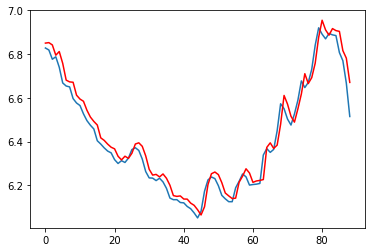

In [36]:
#transform data back the original range
test = np.exp(test)
predictions = np.exp(predictions)

error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)
plt.plot(test)
plt.plot(predictions, color='red')